In [1]:
import os
import cv2
import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as TT
import matplotlib.pyplot as plt
from cnn import SegmentationModel as net
from torch.autograd import Variable
from livelossplot import PlotLosses
from torch.utils.data import Dataset, DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
class MyDataset(torch.utils.data.Dataset):
    '''
    Class to load the dataset
    '''
    def __init__(self, im_dir, im_list, lbl_list, transform = None, img_transform=None):
        '''
        :param imList: image list (Note that these lists have been processed and pickled using the loadData.py)
        :param labelList: label list (Note that these lists have been processed and pickled using the loadData.py)
        '''          
        self.im_dir = im_dir
        self.im_list = im_list
        self.lbl_list = lbl_list      
        self.transform = transform
        self.img_transform = img_transform
        

    def __len__(self):
        return len(self.im_list)

    def __transform__(self, x):
        x = x.copy()
        x = np.moveaxis(x, 2, 0)
        x = x.astype('float')
        x -= 128
        x /= 35
        return(x)

    def __back_transform__(self, x):
        x = x.copy()
        x *= 35
        x += 128
        x[x<0] = 0
        x[x>255] = 255
        x = x.astype('uint8')
        x = np.moveaxis(x, 0, 2)
        return(x)
      
    def __getitem__(self, idx):
        '''

        :param idx: Index of the image file
        :return: returns the image and corresponding label file.
        '''
        image_name = self.im_list[idx]
        label_name = self.lbl_list[idx]
        
        image = cv2.imread(os.path.join(self.im_dir, image_name), cv2.IMREAD_COLOR)
        label = cv2.imread(os.path.join(self.im_dir, label_name), cv2.IMREAD_GRAYSCALE)
        
        if self.transform:
            image, label = self.transform(image, label)
        
        if self.img_transform:
            image = self.img_transform(image)
            image = (image - 0.5) * (255/35)
        else:
            image = self.__transform__(image)
            image = torch.from_numpy(image)
        
        label = torch.from_numpy(label)
        image = Variable(image).to(device, dtype=torch.float)
        label = Variable(label).to(device, dtype=torch.long)
        
        return (image, label)

In [3]:
class Scale(object):
    def __init__(self, h, w):
        self.h = h
        self.w = w
        
    def __call__(self, img, label):
        # nearest neighbour interpolation
        img = cv2.resize(img, (self.w, self.h), interpolation=cv2.INTER_NEAREST)
        label = cv2.resize(label, (self.w, self.h), interpolation=cv2.INTER_NEAREST)

        return [img, label]

class Crop(object):
    def __init__(self, h, w):
        self.y = h
        self.x = w
        
    def __call__(self, img, label):
        h, w = img.shape[:2]
        x1 = np.random.randint(0, w - self.x)
        y1 = np.random.randint(0, h - self.y)
        img_crop = img[y1:y1+self.y, x1:x1+self.x]
        label_crop = label[y1:y1+self.y, x1:x1+self.x]

        return img_crop, label_crop

class RandomCropResize(object):
    def __init__(self, crop_area):
        self.cw = crop_area
        self.ch = crop_area

    def __call__(self, img, label):
        if np.random.random() < 0.5:
            h, w = img.shape[:2]
            x1 = np.random.randint(0, np.min([self.cw, int(w/2)]))
            y1 = np.random.randint(0, np.min([self.ch, int(h/2)]))
            
            img_crop = img[y1:h-y1, x1:w-x1]
            label_crop = label[y1:h-y1, x1:w-x1]

            img_crop = cv2.resize(img_crop, (w, h), interpolation=cv2.INTER_NEAREST)
            label_crop = cv2.resize(label_crop, (w,h), interpolation=cv2.INTER_NEAREST)
            return img_crop, label_crop
        else:
            return [img, label]

class RandomFlip(object):
    def __call__(self, image, label):
        if np.random.random() < 0.5:
                image = cv2.flip(image, 1) # veritcal flip
                label = cv2.flip(label, 1)  # veritcal flip
        return [image, label]


class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, *args):
        for t in self.transforms:
            args = t(*args)
        return args

In [4]:
train_transform = Compose([
    Crop(300, 400),
    RandomCropResize(150),
    RandomFlip(),
    Scale(192, 256)
    ])

val_transform = Compose([
    Crop(300, 400),
    RandomCropResize(150),
    RandomFlip(),
    Scale(192, 256)
    ])

img_transform = TT.Compose([
    TT.ToPILImage(),
    TT.ColorJitter(brightness=0.5, contrast=0.3, saturation=0.1, hue=0.1),
    TT.ToTensor()
])

In [5]:
# Diretorio das imagens
im_dir  = '../../Datasets/Eucalyptus2/Pred3/'
data_dir  = '../data/'

img_ext = '.jpg'
msk_ext = '.png'

imfxy = sorted(os.listdir(im_dir))
# imfxy = imfxy[80:100]
imfx = [i for i in imfxy if i.endswith(img_ext)]
imfx = np.array(imfx)

imfy = [i for i in imfxy if i.endswith(msk_ext) and not i.endswith('_col.png')]
imfy = np.array(imfy)


In [6]:
print(len(imfx), len(imfy))

4093 4093


In [7]:
im_train = np.arange(len(imfx))
brks = np.int0(np.linspace(0, len(imfx), 11))

fold = 0
np.random.seed(12345)
fold_ord = np.random.choice(im_train, len(imfx), replace=False)
im_val = np.sort(fold_ord[brks[fold]:brks[fold +1]])
im_train = np.setdiff1d(im_train,im_val)

In [8]:
train_dataset =  MyDataset(im_dir, imfx[im_train], imfy[im_train], train_transform, img_transform)
val_dataset =  MyDataset(im_dir, imfx[im_val], imfy[im_val], val_transform, img_transform)

In [9]:
print(len(train_dataset), len(val_dataset))

3684 409


In [10]:
# Carrega o dataset de treinamento
train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=50,
                          shuffle=True,
                          num_workers=0
                         )

# Carrega o dataset de validação
val_loader = torch.utils.data.DataLoader(val_dataset,
                          batch_size=50,
                          shuffle=False,
                          num_workers=0
                         )

In [11]:
# Atribui o modelo
model = net.EESPNet_Seg(3, s=0.5, pretrained='', gpus=1)
model = model.to(device)
model.load_state_dict(torch.load('../data/Tracking.pth', map_location=device))


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [12]:
learning_rate = 1e-3
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), learning_rate, (0.9, 0.999), eps=1e-08, weight_decay=5e-4)

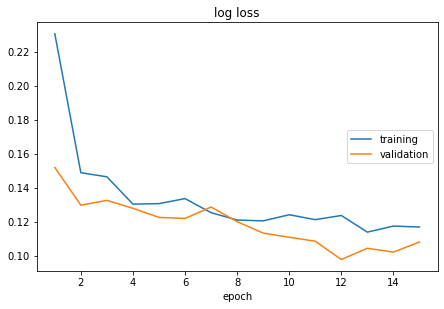

log loss:
training   (min:    0.114, max:    0.230, cur:    0.117)
validation (min:    0.098, max:    0.152, cur:    0.108)
Fold: 0, [3:14] loss: 0.117 time:60.18


KeyboardInterrupt: 

In [13]:
min_loss = 1e9
bad_epochs = 0

liveloss = PlotLosses()
for epoch in range(100):
    bad_epochs += 1
    start_time = time.time()
    epoch_loss = []
    val_loss = []
    
    model.train()
    for (imgs, labels) in train_loader:
        
        #-------------------------------------------
        # Obtem o output
        pred, feat = model(imgs)
        loss = criterion(pred, labels)
        
        # Limpa os gradientes
        optimizer.zero_grad()

        # Obtem os gradientes
        loss.backward()

        # Atualiza os parâmetros
        optimizer.step()

        epoch_loss.append(loss.data.item())
    
    model.eval()
    with torch.no_grad():
        for (imgs, labels) in val_loader:

            pred, feat = model(imgs)
            loss = criterion(pred, labels)

            val_loss.append(loss.data.item())
        
    epoch_loss = np.array(epoch_loss).mean()
    val_loss = np.array(val_loss).mean()
    time_taken = time.time() - start_time
    
    #save the model
    model_file_name = '../data/Trackingff.pth'
    if val_loss < min_loss:
        torch.save(model.state_dict(), model_file_name)
        min_loss = val_loss
        bad_epochs = 0
    if bad_epochs > 100:
        break

    liveloss.update({
        'log loss': epoch_loss,
        'val_log loss': val_loss
    })
    liveloss.draw()
    print('Fold: %d, [%d:%d] loss: %.3f time:%.2f' % (fold, bad_epochs, epoch, epoch_loss, time_taken))
    

In [31]:
# Carrega os pesos de um modelo salvo
model.load_state_dict(torch.load('../data/Trackingff.pth', map_location=device))
# model_file_name = '../data/Tracking.pth'
# torch.save(model.state_dict(), model_file_name)
    
# Coloca em modo de avaliação
model.eval()

print('Modelo OK')

Modelo OK


In [15]:
start_time = time.time()
y_preds = []
y_obs = []
x_obs = []

with torch.no_grad():
    for (imgs, labels) in val_loader:
        # Obtem o output
        pred, feat = model(imgs)
        y_preds.append(pred.cpu().data.numpy())
        x_obs.append(imgs.cpu().data.numpy())
        y_obs.append(labels.cpu().data.numpy())

y_preds = np.concatenate(y_preds)
x_obs = np.concatenate(x_obs)
y_obs = np.concatenate(y_obs)

time_taken = time.time() - start_time
print('time:%.2f' % (time_taken))

time:5.76


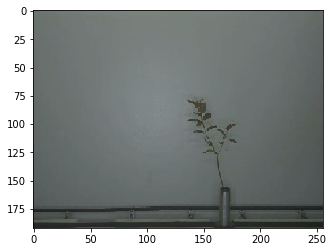

In [28]:
idx = 201
im = train_dataset.__back_transform__(x_obs[idx].copy())
plt.imshow(im[:,:,[2,1,0]])

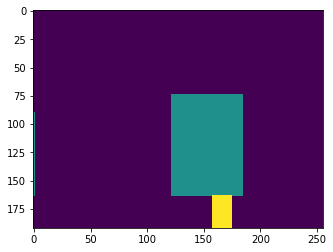

In [29]:
plt.imshow(y_obs[idx])

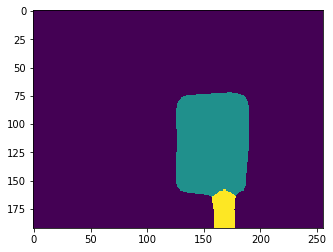

In [30]:
imp = np.moveaxis(y_preds[idx].copy(), 0, 2)
plt.imshow(imp.argmax(2))